# Comparison of Victron Data to Clearsky Model

## Imports

In [75]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *
import solarpanels

## Create Dataframe from Victron Data



                            timestamp (-05:00)   V_mp   P_mp
datetime                                                    
2024-02-07 16:00:00-05:00  2024-02-07 16:00:00  77.66  294.0
2024-02-07 16:00:01-05:00  2024-02-07 16:00:01  77.66  294.0
2024-02-07 16:00:07-05:00  2024-02-07 16:00:07  77.88  293.0
2024-02-07 16:00:11-05:00  2024-02-07 16:00:11  77.65  294.0
2024-02-07 16:00:21-05:00  2024-02-07 16:00:21  77.61  293.0
2024-02-07 16:00:00-05:00 2024-02-07 18:59:53-05:00


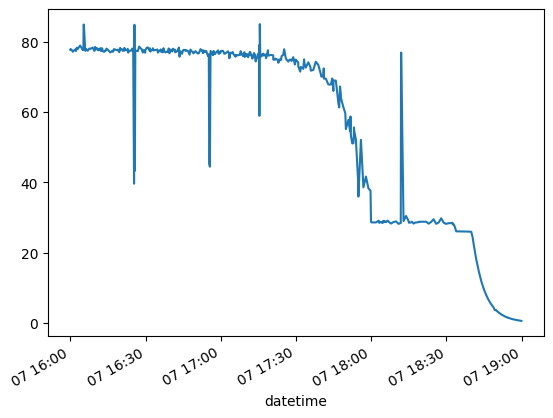

In [76]:
# create dataframe for pv data from sigsby_sunset_2024-2-7.csv
pv_data = pd.read_csv('sigsbee_sunset_2024-2-7.csv')

# convert to datetime
pv_data['datetime'] = pd.to_datetime(pv_data['timestamp (-05:00)'])

# set index to datetime
pv_data = pv_data.set_index('datetime')

# localize to location timezone
pv_data = pv_data.tz_localize(location.tz)

# fill Nan with next value
pv_data = pv_data.bfill()
print(pv_data.head())

pv_data['V_mp'].plot()

# get first and last datetime values
start = pv_data.index[0]
end = pv_data.index[-1]

print(start, end)

## Setup Location and Clearsky

In [77]:
# latitude, longitude, name, altitude, timezone
dredgers_key = (24.5833546, -81.7670295, 'Dredgers Key', 1, 'Etc/GMT+5')
latitude, longitude, name, altitude, timezone = dredgers_key

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

times = pd.date_range(start, end, freq='1s', tz=location.tz)
weather = location.get_clearsky(times)

In [78]:
# Get the date
date = pd.Timestamp(times[0].date()).tz_localize(location.tz)

# Create a DatetimeIndex with the single date
times_single_day = pd.DatetimeIndex([date])

# Get sunrise, sunset, and transit times for the date
result = location.get_sun_rise_set_transit(times_single_day)

# Get sunrise, sunset, and transit times from the DataFrame
sunrise = result['sunrise'].iloc[0]
sunset = result['sunset'].iloc[0]
transit = result['transit'].iloc[0]


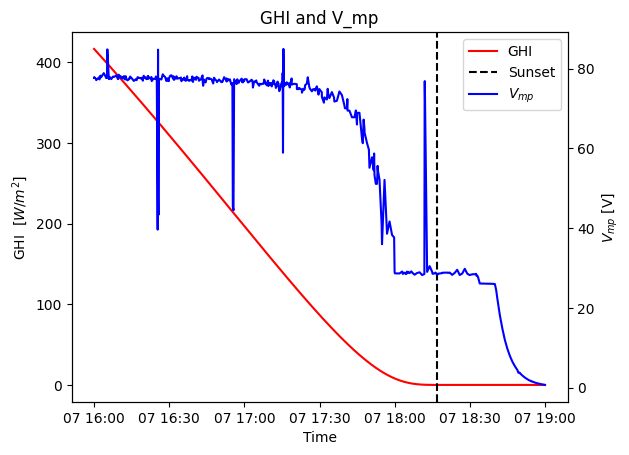

In [79]:
#plot ghi and v_mp on two different y-axes
# plot ghi
fig, ax = plt.subplots()
ax.plot(weather.index, weather['ghi'], 'r', label='GHI')
ax.set_xlabel('Time')

# plot v_mp
ax2 = ax.twinx()
ax2.plot(pv_data.index, pv_data['V_mp'], 'b', label='$V_{mp}$')

# plot sunset
ax.axvline(x=sunset, color='k', linestyle='--', label='Sunset')

# label the y axes
ax.set_ylabel('GHI  $[W/m^{2}]$')
ax2.set_ylabel('$V_{mp}$ [V]')

# combine the legends
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# label the plot
plt.title('GHI and V_mp')
plt.show()



# Setup the System

In [80]:
# Module Parameters
rich_solar_24V_params = solarpanels.get_rich_solar_MEGA200Max_24V()

# Temperature Parameters
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Inverter Parameters
r_batt_wire = 0
r_pv_wire = getWireResistance('12AWG', 30) # based on van build records
mppt_eff = 1.0

mppt_parameters = {
    'v_batt': 26.6,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_24V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=2,
    modules_per_string=2,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )



# Run the Model

In [81]:
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: functools.partial(<function mppt at 0xffff52d88c20>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

# Compare Data to Model

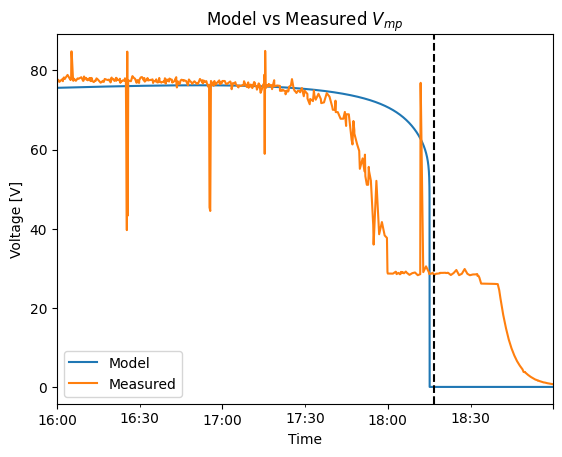

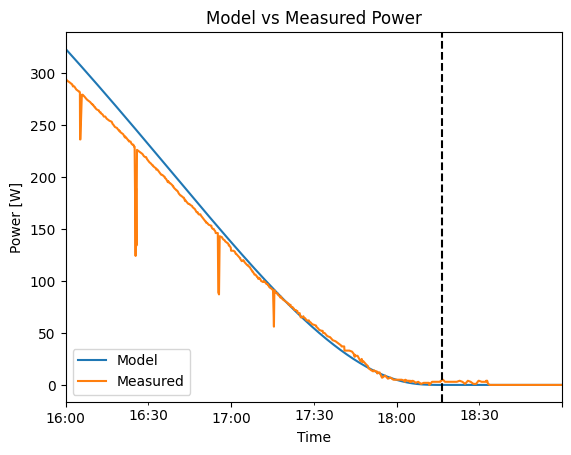

In [82]:
# plot model v_mpp results
(mc.results.dc['v_mp'] - mc.results.dc_ohmic_losses['v_pv_wire_drop']).plot()

# plot measured v_mp
pv_data['V_mp'].plot()

# plot sunset
plt.axvline(x=sunset, color='k', linestyle='--', label='Sunset')

# label the y axes
plt.ylabel('Voltage [V]')
plt.xlabel('Time')

# add a legend
plt.legend(['Model', 'Measured'])

# label the plot
plt.title('Model vs Measured $V_{mp}$')
plt.show()

# on a new figure plot power
fig, ax = plt.subplots()
mc.results.ac.plot()
pv_data['P_mp'].plot()
plt.axvline(x=sunset, color='k', linestyle='--', label='Sunset')

# label the y axes
plt.ylabel('Power [W]')
plt.xlabel('Time')

# add a legend
plt.legend(['Model', 'Measured'])

# label the plot
plt.title('Model vs Measured Power')
plt.show()